In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from keras.models import Sequential, load_model
from keras.layers import *
from keras import optimizers
from keras import utils
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf

# Importing matplotlib to plot images.
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Importing SK-learn to calculate precision and recall
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneGroupOut
from sklearn.utils import shuffle 

# Used for graph export
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras import backend as K

import pickle as pkl
import h5py

from pathlib import Path
import os.path
import sys
import datetime
import time



Using TensorFlow backend.


In [2]:
import telegram
from keras.callbacks import Callback
from callbacks import TelegramCallback
from callbacks.TelegramData import TelegramData


# create callback
config = {
    'token': TelegramData.Token,   # paste your bot token
    'telegram_id': TelegramData.ID,   
    'model_name': "JAN_CNN_01" # paste your telegram_id
}

tg_callback = TelegramCallback(config)

In [3]:
class LoggingTensorBoard(TensorBoard):    

    def __init__(self, log_dir, settings_str_to_log, **kwargs):
        super(LoggingTensorBoard, self).__init__(log_dir, **kwargs)

        self.settings_str = settings_str_to_log

    def on_train_begin(self, logs=None):
        TensorBoard.on_train_begin(self, logs=logs)

        tensor =  tf.convert_to_tensor(self.settings_str)
        summary = tf.summary.text ("Run_Settings", tensor)

        with  tf.Session() as sess:
            s = sess.run(summary)
            self.writer.add_summary(s)

In [11]:
# the data, split between train and test sets
dfAll = pd.read_pickle("PklData/df_blobs.pkl")

lst = dfAll.userID.unique()
np.random.seed(42)
np.random.shuffle(lst)
test_ids = lst[-5:]
train_ids = lst[:-5]
print(train_ids, test_ids)

df_train = dfAll[dfAll.userID.isin(train_ids)]
df_test = dfAll[dfAll.userID.isin(test_ids) & (dfAll.Version == "Normal")]

df_train2 = df_train[['Blobs', 'InputMethod']].copy()
df_test2 = df_test[['Blobs', 'InputMethod']].copy()

[ 1  2  9  6  4 14 17 16 12  3 10 18  5] [13  8 11 15  7]


In [12]:
x_train = np.vstack(df_train2.Blobs)
x_test = np.vstack(df_test2.Blobs)
y_train = df_train2.InputMethod.values
y_test = df_test2.InputMethod.values

x_train = x_train.reshape(-1, 27, 15, 1)
x_test = x_test.reshape(-1, 27, 15, 1)

In [13]:
# convert class vectors to binary class matrices (one-hot notation)
num_classes = 2
y_train_one_hot = utils.to_categorical(df_train2.InputMethod, num_classes)
y_test_one_hot = utils.to_categorical(df_test2.InputMethod, num_classes)

Text(0.5, 1.0, 'Label for image 1 is: 0')

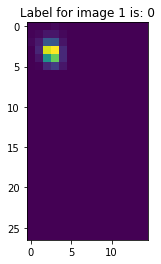

In [14]:
i = 1
plt.imshow(x_train[i].reshape(27, 15)) #np.sqrt(784) = 28
plt.title("Label for image %i is: %s" % (i, y_train[i]))

In [15]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
#config = tf.ConfigProto(device_count = {"GPU": 1})


# If GPU is available: 
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allow_growth=True
config.gpu_options.allocator_type = 'BFC'

# Limit the maximum memory used
config.gpu_options.per_process_gpu_memory_fraction = 0.4

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

In [16]:
from keras import regularizers

In [ ]:

tf.get_default_graph()
########## HYPER PARAMETERS

batch_size = 100
epochs = 10000
optimizer = optimizers.Adam(lr=0.001)

l1v = 0.007
l2v = 0.014
#optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.1)
#init=tf.global_variables_initializer()

########## HYPER PARAMETERS
########## MODEL ARCHITECTURE
model = Sequential()
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(27,15,1), 
                 kernel_regularizer=regularizers.l1_l2(l1v,l2v)))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', 
                 kernel_regularizer=regularizers.l1_l2(l1v,l2v)))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='same', data_format='channels_last'))
model.add(Dropout(0.45))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1_l2(l1v,l2v)))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1_l2(l1v,l2v)))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='same', data_format='channels_last'))
model.add(Dropout(0.45))

model.add(Flatten())
model.add(Dense(140, activation='relu', kernel_regularizer=regularizers.l1_l2(l1v,l2v), use_bias=True))
model.add(Dropout(0.55))
model.add(Dense(70, activation='relu', kernel_regularizer=regularizers.l1_l2(l1v,l2v), use_bias=True))
model.add(Dropout(0.55))
model.add(Dense(num_classes, activation='softmax'))
########## MODEL ARCHITECTURE
####TENSORBOARD
config = ""
for layer in model.layers:
    config += str(layer.output).split('\"')[1].split("/")[0] + str(layer.output_shape) + "\n\n"
#### END TENSORBOARD
config += "batchsize: " + str(batch_size) + "\n\n" + "epochs: " + str(epochs) + "\n\n"

# Print summary
model.summary()
current_name = "KnuckleFinger_Jan_v3"
readable_timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')
tensorflowfolder = "/srv/share/tensorboardfiles/" + current_name + readable_timestamp
print(current_name + readable_timestamp)
logger = LoggingTensorBoard(settings_str_to_log = config, log_dir=tensorflowfolder, histogram_freq=0,
                            write_graph=True, write_images=True, update_freq = 'epoch')
storer = ModelCheckpoint("./ModelSnapshots/" + current_name + readable_timestamp + ".h5", monitor='val_loss', verbose=0,
                         save_best_only=True, save_weights_only=False, mode='auto', period=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=140, 
                                            verbose=1, 
                                            factor=0.95, 
                                            min_lr=0.00001)
# compile model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(x_train, y_train_one_hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test_one_hot),
                    callbacks=[logger, storer, learning_rate_reduction, tg_callback])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 27, 15, 128)       1280      
_________________________________________________________________
batch_normalization_9 (Batch (None, 27, 15, 128)       512       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 27, 15, 64)        73792     
_________________________________________________________________
batch_normalization_10 (Batc (None, 27, 15, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 8, 64)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 8, 64)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 8, 64)         36928     
__________

285412/285412 [==============================] - 72s 251us/step - loss: 0.5668 - acc: 0.9150 - val_loss: 0.6727 - val_acc: 0.8852
Epoch 39/10000
285412/285412 [==============================] - 72s 251us/step - loss: 0.5582 - acc: 0.9151 - val_loss: 0.5281 - val_acc: 0.9109
Epoch 40/10000
285412/285412 [==============================] - 72s 251us/step - loss: 0.5611 - acc: 0.9139 - val_loss: 0.5063 - val_acc: 0.9337
Epoch 41/10000
285412/285412 [==============================] - 72s 251us/step - loss: 0.5642 - acc: 0.9148 - val_loss: 0.5598 - val_acc: 0.9224
Epoch 42/10000
285412/285412 [==============================] - 72s 252us/step - loss: 0.5616 - acc: 0.9152 - val_loss: 0.5077 - val_acc: 0.9312
Epoch 43/10000
285412/285412 [==============================] - 72s 253us/step - loss: 0.5612 - acc: 0.9160 - val_loss: 0.5384 - val_acc: 0.8966
Epoch 44/10000
285412/285412 [==============================] - 72s 251us/step - loss: 0.5597 - acc: 0.9162 - val_loss: 0.5114 - val_acc: 0.9292


285412/285412 [==============================] - 72s 252us/step - loss: 0.5535 - acc: 0.9131 - val_loss: 0.5269 - val_acc: 0.8951
Epoch 95/10000
285412/285412 [==============================] - 72s 252us/step - loss: 0.5574 - acc: 0.9118 - val_loss: 0.5260 - val_acc: 0.9086
Epoch 96/10000
285412/285412 [==============================] - 72s 251us/step - loss: 0.5558 - acc: 0.9124 - val_loss: 0.4913 - val_acc: 0.9260
Epoch 97/10000
285412/285412 [==============================] - 72s 252us/step - loss: 0.5548 - acc: 0.9124 - val_loss: 0.5559 - val_acc: 0.9121
Epoch 98/10000
285412/285412 [==============================] - 72s 251us/step - loss: 0.5530 - acc: 0.9138 - val_loss: 0.4717 - val_acc: 0.9377
Epoch 99/10000
285412/285412 [==============================] - 72s 251us/step - loss: 0.5526 - acc: 0.9126 - val_loss: 0.4989 - val_acc: 0.9323
Epoch 100/10000
285412/285412 [==============================] - 72s 252us/step - loss: 0.5535 - acc: 0.9135 - val_loss: 0.4951 - val_acc: 0.9397

285412/285412 [==============================] - 72s 251us/step - loss: 0.5536 - acc: 0.9136 - val_loss: 0.4909 - val_acc: 0.9326
Epoch 151/10000
285412/285412 [==============================] - 72s 251us/step - loss: 0.5557 - acc: 0.9131 - val_loss: 0.4832 - val_acc: 0.9335
Epoch 152/10000
285412/285412 [==============================] - 72s 251us/step - loss: 0.5513 - acc: 0.9129 - val_loss: 0.5490 - val_acc: 0.8966
Epoch 153/10000
285412/285412 [==============================] - 72s 251us/step - loss: 0.5546 - acc: 0.9129 - val_loss: 0.4859 - val_acc: 0.9306
Epoch 154/10000
285412/285412 [==============================] - 72s 251us/step - loss: 0.5547 - acc: 0.9143 - val_loss: 0.4883 - val_acc: 0.9315
Epoch 155/10000
285412/285412 [==============================] - 71s 250us/step - loss: 0.5540 - acc: 0.9127 - val_loss: 0.5145 - val_acc: 0.9286
Epoch 156/10000
285412/285412 [==============================] - 72s 252us/step - loss: 0.5506 - acc: 0.9137 - val_loss: 0.4990 - val_acc: 0

In [ ]:
# use model for inference to get test accuracy
y_test_pred = model.predict(x_test)
y_test_pred = np.argmax(y_test_pred, axis=1)

print ('\n Summary of the precision, recall, F1 score for each class:')
print (sklearn.metrics.classification_report(y_test, y_test_pred))

print ('\n Confusion matrix: ')
print (sklearn.metrics.confusion_matrix(y_test, y_test_pred))

In [ ]:
print("end")

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_acc'], label="Test Accuracy")
plt.plot(history.history['acc'], label="Training Accuracy")
plt.legend()
plt.savefig("final_CNN.jpg")

In [ ]:
# save model
model.save("CNN_01_03_19_final.h5")

In [ ]:
model.predict(x_train, batch_size=500, verbose=0)

In [ ]:
y_train_one_hot

In [ ]:
train_prediction=np.round(model.predict(x_train))
train_prediction=train_prediction.astype(int)

In [ ]:
val_prediction=np.round(model.predict(x_test))
val_prediction=val_prediction.astype(int)

In [ ]:
delta = val_prediction - y_test_one_hot
indices = []
for i in range(len(val_prediction)):
    if np.count_nonzero(delta[i]) > 0:
        indices += [i]

In [ ]:
len(indices)

In [ ]:
imagelist = []
for data_point in indices:
    print(data_point)
    plt.close()
    plt.clf()
    plt.cla()
    #plt.subplot(figsize=(6,6))
    plt.figure(figsize=(6, 6))
    ax = plt.gca()
    
    
    
    data_point = indices[0]
    data = df_train.Blobs.iloc[data_point]
    label = "Knuckle" if train_prediction[data_point][0] == 1 else "Finger"  
    ax.set_title("Input method: " + str(df_train.InputMethod.iloc[data_point]) + "\n" + "Label as: "  + label)
    #plt.imsave("PredictionImages/" + str(data_point)+".pdf", data, cmap='gray', vmin=0, vmax=255)
    plt.imsave("PredictionImages/{}.png".format(data_point), data, cmap="gray", vmin=0, vmax=255)
    #plt.close()


In [ ]:
from fpdf import FPDF

In [ ]:
incorrects